In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from torchvision.ops import SqueezeExcitation
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading data

In [2]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.n_samples = 0
        self.dataset = []
        self.labels = set()  # To track unique labels
        self.load_audio_files(self.data_dir)

    def load_audio_files(self, path: str):
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                
                # label = dirname.split('/')[-1]  # on MAC 
                label = os.path.basename(dirname)   # on Windows
       
                # my implementation start
                if '0' <= label <= '9':
                    label_index = ord(label) - ord('0')
                    # print(label_index)
                elif 'a' <= label <= 'z':
                    label_index = ord(label) - ord('a') + 10
                    # print(label_index)
                else:
                    raise ValueError(f"Unexpected label: {label}")
                    break
                label_tensor = torch.tensor(label_index)
                # my implementation done
                
                # Add the label to the set of unique labels
                self.labels.add(label_tensor.item())
                
                # Load audio
                waveform, sample_rate = torchaudio.load(file_path)
                if self.transform is not None:
                    waveform_transformed = self.transform(waveform)
                
                if waveform_transformed.shape[2] != 64:
                    print("Wrong shape:", waveform_transformed.shape)
                    continue
                
                self.n_samples += 1
                self.dataset.append((waveform, label_tensor))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        waveform, label = self.dataset[idx]
        return waveform, label

    def num_classes(self):
        return len(self.labels)  # Return the number of unique labels

In [3]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=2048, win_length=1024)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset = AudioDataset('../../new_dataset_phone', transforms)
print("number of classes:", dataset.num_classes())

number of classes: 36


In [ ]:
from sklearn.model_selection import train_test_split
import torch

# Assume your dataset has a 'targets' attribute or you can extract labels from it
targets = [data[1] for data in dataset]  # Assuming dataset returns (data, label) pairs

# Split the dataset indices with stratification
train_indices, tmp_indices = train_test_split(
    range(len(dataset)), 
    test_size=0.3,  # 30% of the data goes to val+test
    stratify=targets
)

val_indices, test_indices = train_test_split(
    tmp_indices, 
    test_size=0.33,  # 33% of the 30% goes to the test set, i.e., 10% of the original dataset
    stratify=[targets[i] for i in tmp_indices]
)

# Create subsets of the dataset based on the indices
init_train_set = torch.utils.data.Subset(dataset, train_indices)
init_val_set = torch.utils.data.Subset(dataset, val_indices)
init_test_set = torch.utils.data.Subset(dataset, test_indices)

# Print the sizes for verification
print("Sample rate:", sample_rate)
print(f"Train set size: {len(init_train_set)}, Validation set size: {len(init_val_set)}, Test set size: {len(init_test_set)}")


Sample rate: 44100
Train set size: 630, Validation set size: 180, Test set size: 90


### Data augmentation setup

In [5]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [6]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [7]:
aug_transforms = Compose([
    TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])

train_set = TrainingDataset(init_train_set, aug_transforms)
train_set_no_aug = TrainingDataset(init_train_set, transforms)
val_set = TrainingDataset(init_val_set, transforms)
test_set = TrainingDataset(init_test_set, transforms)

### Training set image (augmented vs non-augmented)

torch.Size([64, 64])


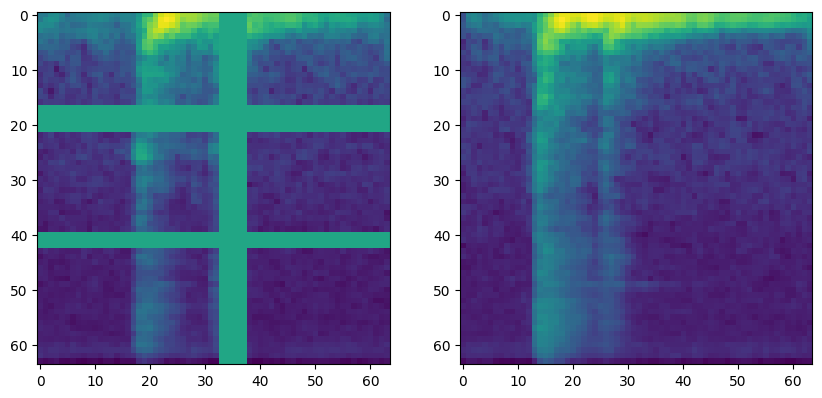

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_set[0][0][0], cmap='viridis')
ax2.imshow(val_set[0][0][0], cmap='viridis')
print(train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [9]:
print("number of classes:", dataset.num_classes())

number of classes: 36


### CoAtNet (Model)

In [10]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [11]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [12]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [13]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [14]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [15]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [16]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [18]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [19]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [20]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

c:\Users\user\miniconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

### Training

In [23]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [24]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [25]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [26]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [27]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [28]:
best_model_path = "CoAtNet-1-Best-Phone.pkl"
model_path = "CoAtNet-1-Phone.pkl"

Epoch [1/1100], Loss: 12.70757007598877, Accuracy: 0.025396825396825397 Correct: 16 Total: 630 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.05 Validation loss: 22.545825958251953 Correct: 9 Total: 180
Epoch [2/1100], Loss: 6.464266300201416, Accuracy: 0.03333333333333333 Correct: 21 Total: 630 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.03333333333333333 Validation loss: 14.754417419433594 Correct: 6 Total: 180
Epoch [3/1100], Loss: 5.78790283203125, Accuracy: 0.04285714285714286 Correct: 27 Total: 630 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.05 Validation loss: 9.935401916503906 Correct: 9 Total: 180
Epoch [4/1100], Loss: 5.512740612030029, Accuracy: 0.03492063492063492 Correct: 22 Total: 630 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.044444444444444446 Validation loss: 6.165587425231934 Correct: 8 Total: 180
Epoch [5/1100], Loss: 6.029965877532959, Accuracy: 0.04285714285714286 C

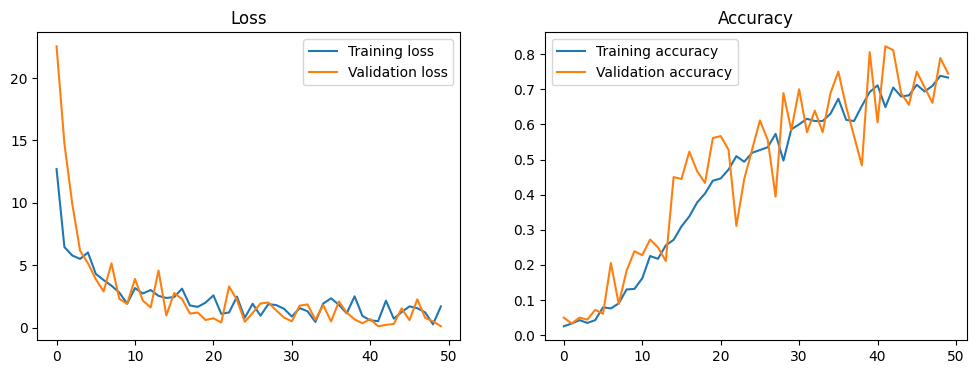

Epoch [51/1100], Loss: 0.8652698993682861, Accuracy: 0.7206349206349206 Correct: 454 Total: 630 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.8666666666666667 Validation loss: 0.879343569278717 Correct: 156 Total: 180
Epoch [52/1100], Loss: 0.9930374026298523, Accuracy: 0.7285714285714285 Correct: 459 Total: 630 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.7111111111111111 Validation loss: 1.132888913154602 Correct: 128 Total: 180
Epoch [53/1100], Loss: 1.4389756917953491, Accuracy: 0.7047619047619048 Correct: 444 Total: 630 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.7333333333333333 Validation loss: 1.024561882019043 Correct: 132 Total: 180
Epoch [54/1100], Loss: 1.191175103187561, Accuracy: 0.7428571428571429 Correct: 468 Total: 630 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.7722222222222223 Validation loss: 0.41057294607162476 Correct: 139 Total: 180
Epoch [55/110

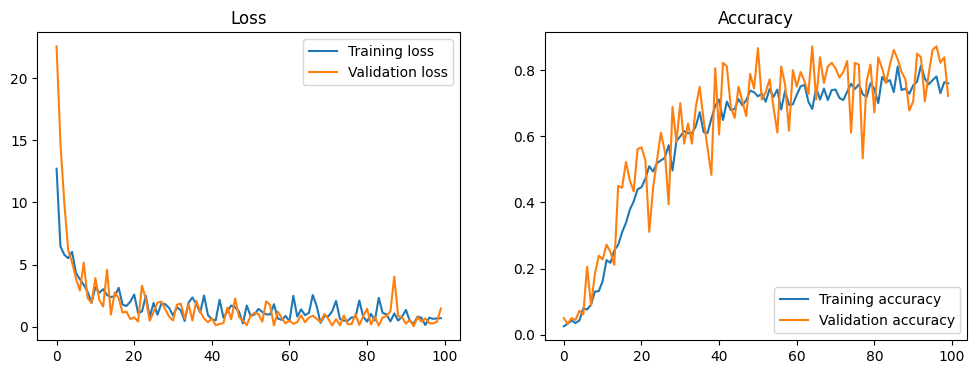

Epoch [101/1100], Loss: 0.5920724868774414, Accuracy: 0.7777777777777778 Correct: 490 Total: 630 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.8055555555555556 Validation loss: 0.17481166124343872 Correct: 145 Total: 180
Epoch [102/1100], Loss: 1.3969368934631348, Accuracy: 0.7396825396825397 Correct: 466 Total: 630 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.7 Validation loss: 0.9714720249176025 Correct: 126 Total: 180
Epoch [103/1100], Loss: 1.0153096914291382, Accuracy: 0.7412698412698413 Correct: 467 Total: 630 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.8277777777777777 Validation loss: 0.44424358010292053 Correct: 149 Total: 180
Epoch [104/1100], Loss: 0.7510504126548767, Accuracy: 0.7476190476190476 Correct: 471 Total: 630 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.9388888888888889 Validation loss: 0.13141584396362305 Correct: 169 Total: 180
Epoch [105/1100],

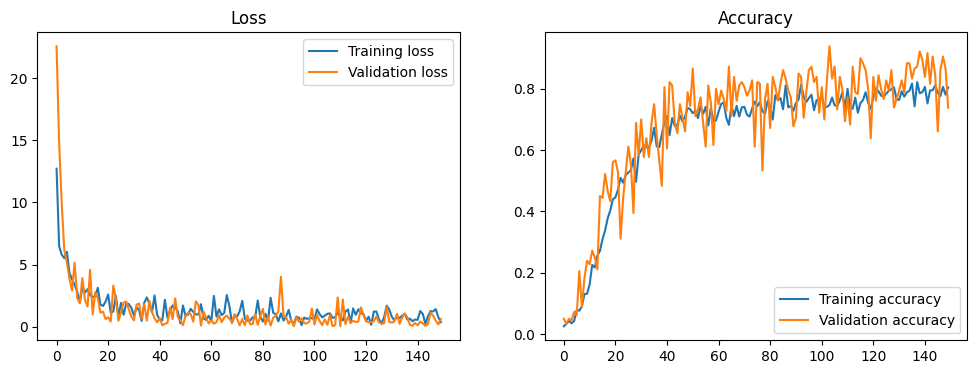

Epoch [151/1100], Loss: 0.34031784534454346, Accuracy: 0.8301587301587302 Correct: 523 Total: 630 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.8666666666666667 Validation loss: 0.588756799697876 Correct: 156 Total: 180
Epoch [152/1100], Loss: 0.6624787449836731, Accuracy: 0.7968253968253968 Correct: 502 Total: 630 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.7722222222222223 Validation loss: 0.9442623853683472 Correct: 139 Total: 180
Epoch [153/1100], Loss: 1.3861316442489624, Accuracy: 0.8047619047619048 Correct: 507 Total: 630 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.8722222222222222 Validation loss: 0.7003960609436035 Correct: 157 Total: 180
Epoch [154/1100], Loss: 0.7946280837059021, Accuracy: 0.7523809523809524 Correct: 474 Total: 630 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.9388888888888889 Validation loss: 0.09110250324010849 Correct: 169 Total: 180
Epoch

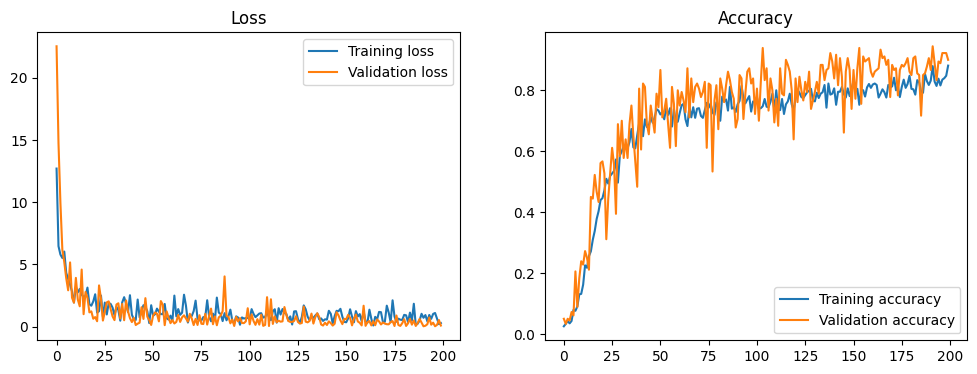

Epoch [201/1100], Loss: 0.871025025844574, Accuracy: 0.8523809523809524 Correct: 537 Total: 630 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8277777777777777 Validation loss: 0.042827308177948 Correct: 149 Total: 180
Epoch [202/1100], Loss: 0.42593732476234436, Accuracy: 0.7984126984126985 Correct: 503 Total: 630 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.9111111111111111 Validation loss: 0.24526309967041016 Correct: 164 Total: 180
Epoch [203/1100], Loss: 0.5050110220909119, Accuracy: 0.8222222222222222 Correct: 518 Total: 630 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8944444444444445 Validation loss: 0.11305038630962372 Correct: 161 Total: 180
Epoch [204/1100], Loss: 1.2631651163101196, Accuracy: 0.8126984126984127 Correct: 512 Total: 630 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8 Validation loss: 0.08645933866500854 Correct: 144 Total: 180
Epoch [205/1100],

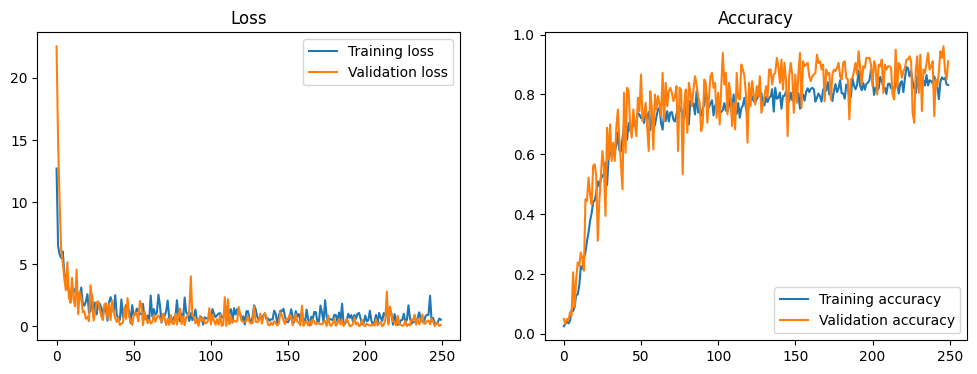

Epoch [251/1100], Loss: 0.7258854508399963, Accuracy: 0.8492063492063492 Correct: 535 Total: 630 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.9277777777777778 Validation loss: 0.09151154011487961 Correct: 167 Total: 180
Epoch [252/1100], Loss: 0.3968776762485504, Accuracy: 0.8492063492063492 Correct: 535 Total: 630 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.9444444444444444 Validation loss: 0.09940947592258453 Correct: 170 Total: 180
Epoch [253/1100], Loss: 0.3684016764163971, Accuracy: 0.8952380952380953 Correct: 564 Total: 630 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.9 Validation loss: 0.23904457688331604 Correct: 162 Total: 180
Epoch [254/1100], Loss: 0.6476360559463501, Accuracy: 0.846031746031746 Correct: 533 Total: 630 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.8833333333333333 Validation loss: 0.24713614583015442 Correct: 159 Total: 180
Epoch [255/1100]

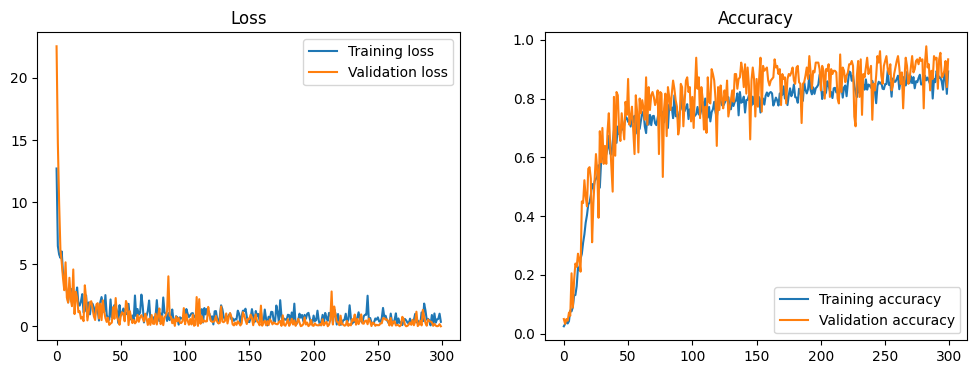

Epoch [301/1100], Loss: 0.4506925642490387, Accuracy: 0.8873015873015873 Correct: 559 Total: 630 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8722222222222222 Validation loss: 0.049290865659713745 Correct: 157 Total: 180
Epoch [302/1100], Loss: 0.24605441093444824, Accuracy: 0.8857142857142857 Correct: 558 Total: 630 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.95 Validation loss: 0.11553284525871277 Correct: 171 Total: 180
Epoch [303/1100], Loss: 0.6318387985229492, Accuracy: 0.8825396825396825 Correct: 556 Total: 630 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.9055555555555556 Validation loss: 0.3850916624069214 Correct: 163 Total: 180
Epoch [304/1100], Loss: 0.1570281684398651, Accuracy: 0.8857142857142857 Correct: 558 Total: 630 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.9555555555555556 Validation loss: 0.03972494229674339 Correct: 172 Total: 180
Epoch [305/11

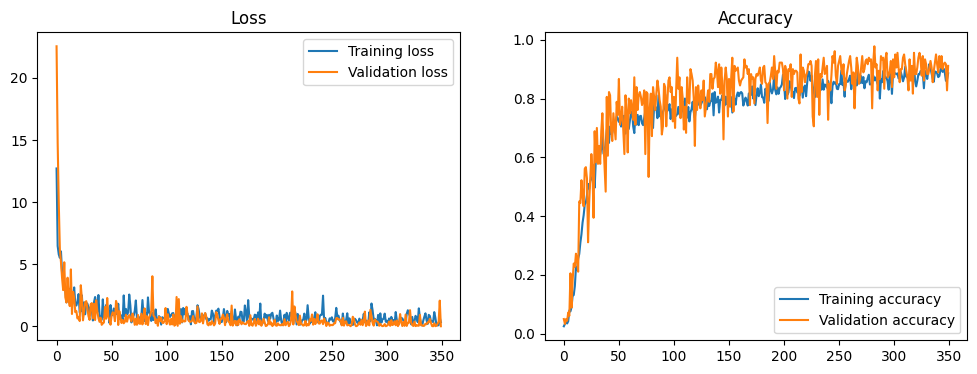

Epoch [351/1100], Loss: 0.6830270886421204, Accuracy: 0.8809523809523809 Correct: 555 Total: 630 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.8944444444444445 Validation loss: 0.05939171463251114 Correct: 161 Total: 180
Epoch [352/1100], Loss: 0.5825254321098328, Accuracy: 0.8793650793650793 Correct: 554 Total: 630 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9166666666666666 Validation loss: 0.48677507042884827 Correct: 165 Total: 180
Epoch [353/1100], Loss: 0.6939308643341064, Accuracy: 0.9126984126984127 Correct: 575 Total: 630 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.9166666666666666 Validation loss: 1.9951766729354858 Correct: 165 Total: 180
Epoch [354/1100], Loss: 0.8139693737030029, Accuracy: 0.8809523809523809 Correct: 555 Total: 630 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.8333333333333334 Validation loss: 0.06950904428958893 Correct: 150 Total: 180
Epoc

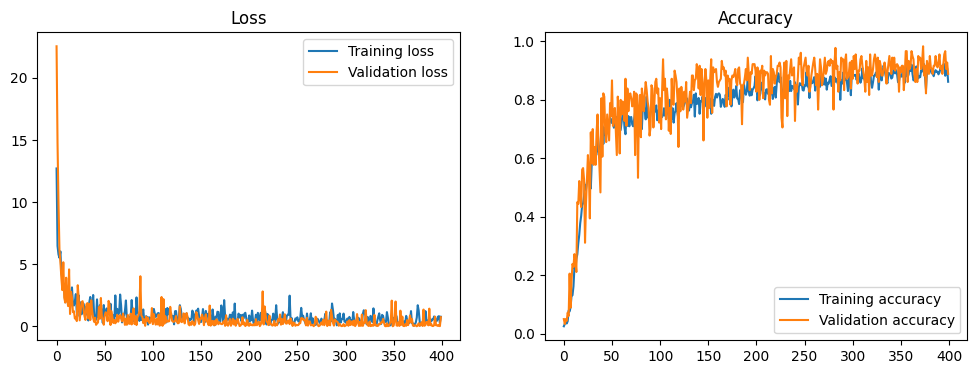

Epoch [401/1100], Loss: 0.21332092583179474, Accuracy: 0.9047619047619048 Correct: 570 Total: 630 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.9388888888888889 Validation loss: 0.329021692276001 Correct: 169 Total: 180
Epoch [402/1100], Loss: 0.8235971927642822, Accuracy: 0.8809523809523809 Correct: 555 Total: 630 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.9 Validation loss: 0.02684006653726101 Correct: 162 Total: 180
Epoch [403/1100], Loss: 0.1208629235625267, Accuracy: 0.8968253968253969 Correct: 565 Total: 630 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.9388888888888889 Validation loss: 0.03548206016421318 Correct: 169 Total: 180
Epoch [404/1100], Loss: 0.42774248123168945, Accuracy: 0.8936507936507937 Correct: 563 Total: 630 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.9444444444444444 Validation loss: 0.07055899500846863 Correct: 170 Total: 180
Epoch [405/1100

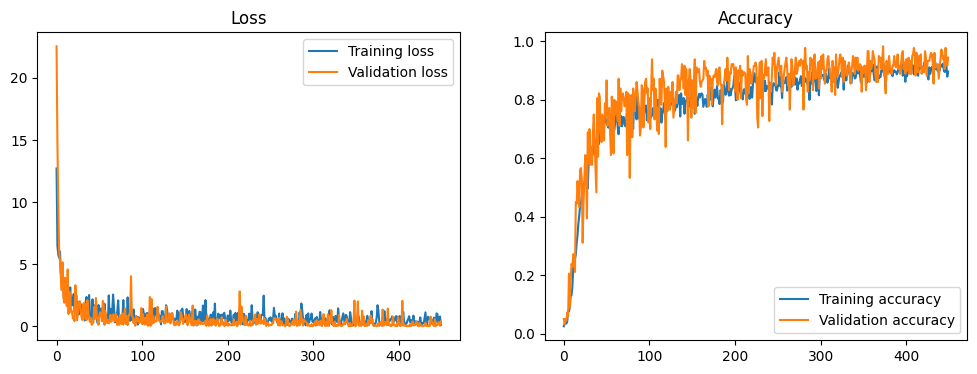

Epoch [451/1100], Loss: 0.2527448832988739, Accuracy: 0.9079365079365079 Correct: 572 Total: 630 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.9055555555555556 Validation loss: 1.3232797384262085 Correct: 163 Total: 180
Epoch [452/1100], Loss: 0.12555061280727386, Accuracy: 0.9253968253968254 Correct: 583 Total: 630 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.95 Validation loss: 0.6312114596366882 Correct: 171 Total: 180
Epoch [453/1100], Loss: 0.9396109580993652, Accuracy: 0.8857142857142857 Correct: 558 Total: 630 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.9444444444444444 Validation loss: 1.283545970916748 Correct: 170 Total: 180
Epoch [454/1100], Loss: 1.5517559051513672, Accuracy: 0.8746031746031746 Correct: 551 Total: 630 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.8666666666666667 Validation loss: 0.08753844350576401 Correct: 156 Total: 180
Epoch [455/1100], L

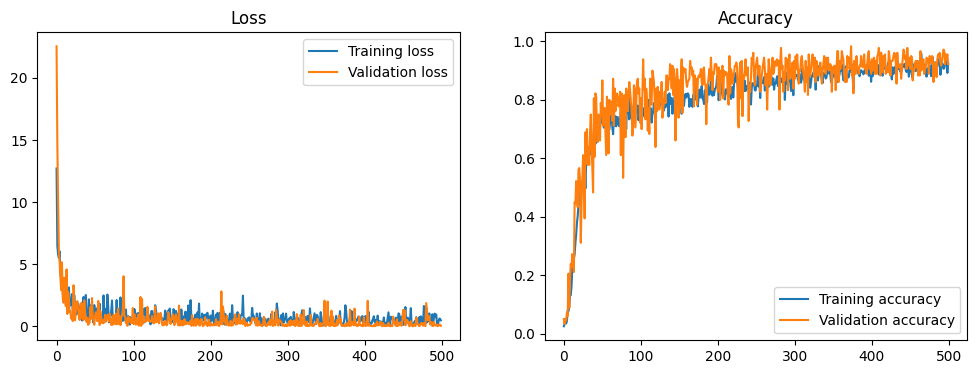

Epoch [501/1100], Loss: 1.215868592262268, Accuracy: 0.8968253968253969 Correct: 565 Total: 630 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.9166666666666666 Validation loss: 0.008552547544240952 Correct: 165 Total: 180
Epoch [502/1100], Loss: 0.23378197848796844, Accuracy: 0.9 Correct: 567 Total: 630 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.9333333333333333 Validation loss: 0.13135617971420288 Correct: 168 Total: 180
Epoch [503/1100], Loss: 0.4063716232776642, Accuracy: 0.9412698412698413 Correct: 593 Total: 630 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9722222222222222 Validation loss: 0.107244573533535 Correct: 175 Total: 180
Epoch [504/1100], Loss: 0.19094975292682648, Accuracy: 0.9349206349206349 Correct: 589 Total: 630 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.9666666666666667 Validation loss: 0.6358472108840942 Correct: 174 Total: 180
Epoch [505/1100]

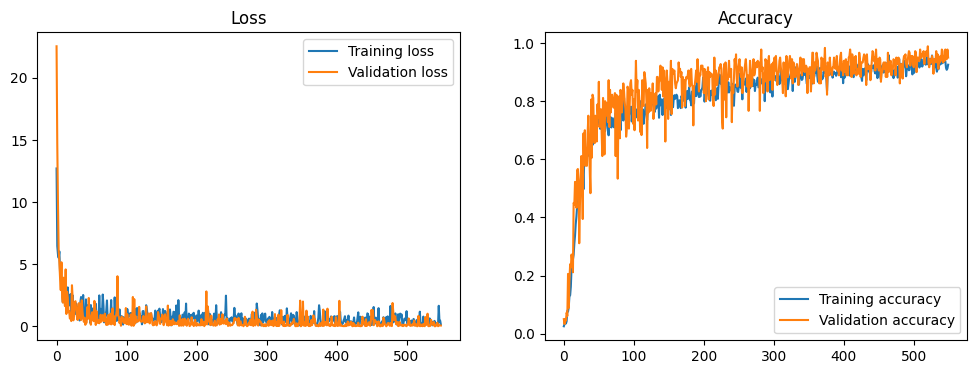

Epoch [551/1100], Loss: 0.3777182400226593, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.95 Validation loss: 0.02236785925924778 Correct: 171 Total: 180
Epoch [552/1100], Loss: 0.12806686758995056, Accuracy: 0.9253968253968254 Correct: 583 Total: 630 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.95 Validation loss: 0.3549719452857971 Correct: 171 Total: 180
Epoch [553/1100], Loss: 0.3573331832885742, Accuracy: 0.9206349206349206 Correct: 580 Total: 630 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.9055555555555556 Validation loss: 0.08938824385404587 Correct: 163 Total: 180
Epoch [554/1100], Loss: 0.3928980827331543, Accuracy: 0.9 Correct: 567 Total: 630 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.9166666666666666 Validation loss: 0.5224253535270691 Correct: 165 Total: 180
Epoch [555/1100], Loss: 0.1991186887025833, A

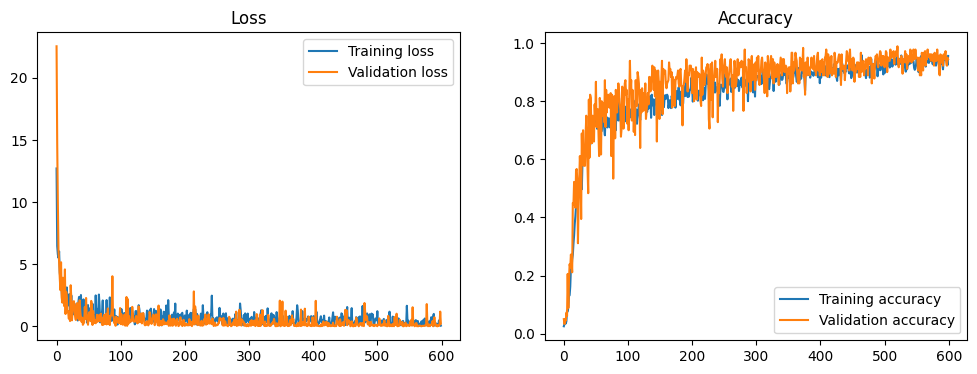

Epoch [601/1100], Loss: 0.08780597895383835, Accuracy: 0.926984126984127 Correct: 584 Total: 630 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.9388888888888889 Validation loss: 0.08686380088329315 Correct: 169 Total: 180
Epoch [602/1100], Loss: 0.5433622598648071, Accuracy: 0.9428571428571428 Correct: 594 Total: 630 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9722222222222222 Validation loss: 0.2833867073059082 Correct: 175 Total: 180
Epoch [603/1100], Loss: 0.25973284244537354, Accuracy: 0.9206349206349206 Correct: 580 Total: 630 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.9888888888888889 Validation loss: 0.003952458966523409 Correct: 178 Total: 180
Epoch [604/1100], Loss: 0.28149762749671936, Accuracy: 0.9396825396825397 Correct: 592 Total: 630 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9611111111111111 Validation loss: 0.11424240469932556 Correct: 173 Total: 

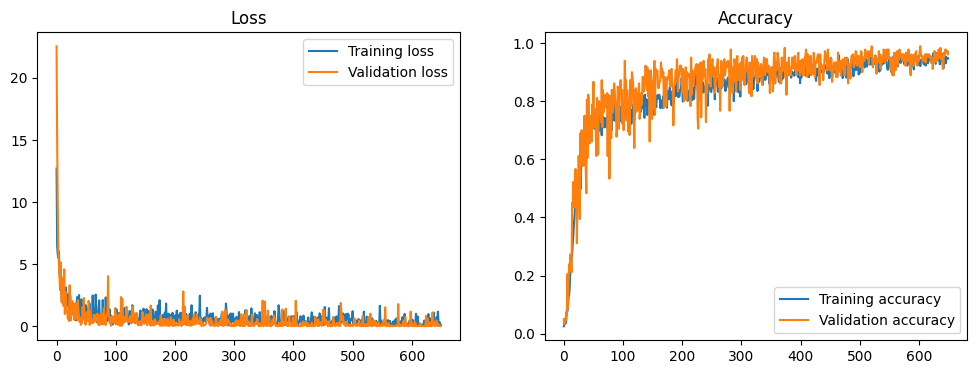

Epoch [651/1100], Loss: 0.08099068701267242, Accuracy: 0.9396825396825397 Correct: 592 Total: 630 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9611111111111111 Validation loss: 0.15823714435100555 Correct: 173 Total: 180
Epoch [652/1100], Loss: 0.05588218942284584, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.9777777777777777 Validation loss: 0.3439491391181946 Correct: 176 Total: 180
Epoch [653/1100], Loss: 0.03842582926154137, Accuracy: 0.9412698412698413 Correct: 593 Total: 630 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.95 Validation loss: 0.027920853346586227 Correct: 171 Total: 180
Epoch [654/1100], Loss: 0.30903109908103943, Accuracy: 0.9603174603174603 Correct: 605 Total: 630 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9444444444444444 Validation loss: 0.010856819339096546 Correct: 170 Total: 180
Epoch [655

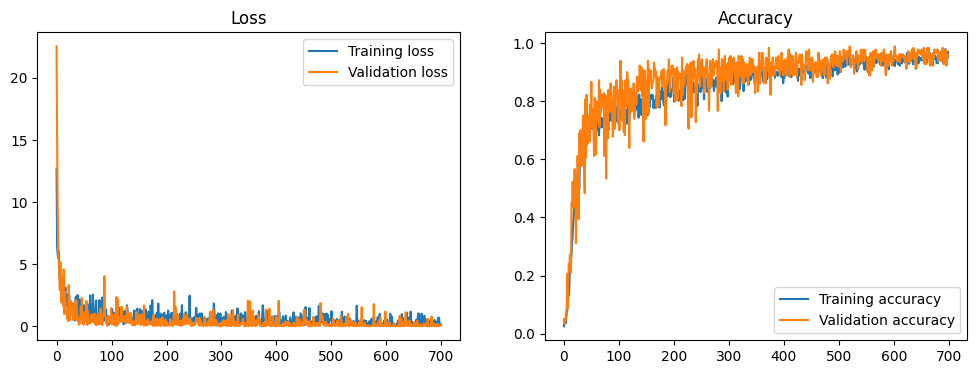

Epoch [701/1100], Loss: 0.19166570901870728, Accuracy: 0.9428571428571428 Correct: 594 Total: 630 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9722222222222222 Validation loss: 0.07032375782728195 Correct: 175 Total: 180
Epoch [702/1100], Loss: 0.10140005499124527, Accuracy: 0.953968253968254 Correct: 601 Total: 630 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9444444444444444 Validation loss: 0.04138597846031189 Correct: 170 Total: 180
Epoch [703/1100], Loss: 0.18431174755096436, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9388888888888889 Validation loss: 1.249629259109497 Correct: 169 Total: 180
Epoch [704/1100], Loss: 0.2940354347229004, Accuracy: 0.9317460317460318 Correct: 587 Total: 630 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9277777777777778 Validation loss: 0.13607189059257507 Correct: 167 Total: 180


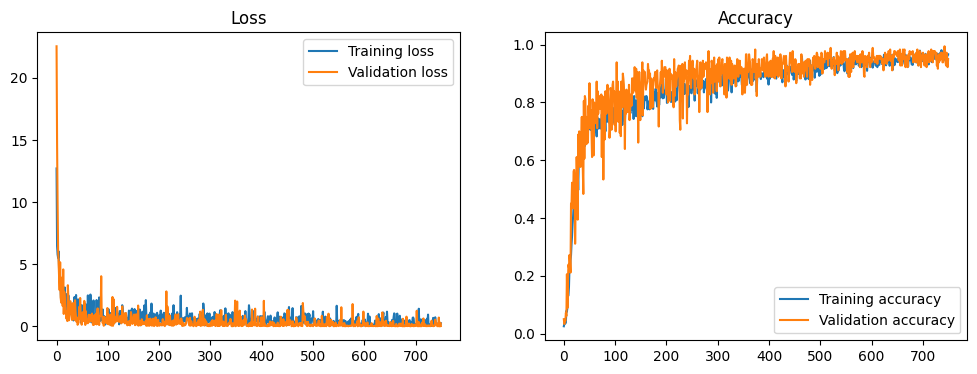

Epoch [751/1100], Loss: 0.0649036392569542, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9611111111111111 Validation loss: 0.021838944405317307 Correct: 173 Total: 180
Epoch [752/1100], Loss: 0.063554547727108, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9777777777777777 Validation loss: 0.009420358575880527 Correct: 176 Total: 180
Epoch [753/1100], Loss: 0.31130680441856384, Accuracy: 0.953968253968254 Correct: 601 Total: 630 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9666666666666667 Validation loss: 0.09494508802890778 Correct: 174 Total: 180
Epoch [754/1100], Loss: 0.7540990710258484, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9666666666666667 Validation loss: 0.2789643704891205 Correct: 174 Total: 180


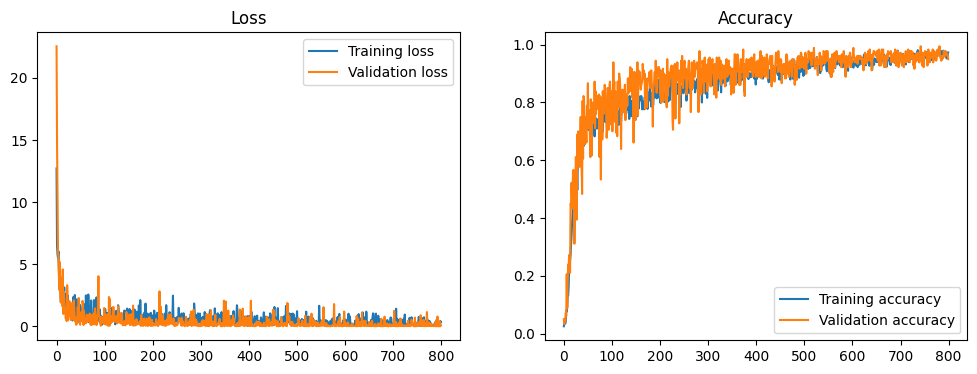

Epoch [801/1100], Loss: 0.28925856947898865, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9555555555555556 Validation loss: 0.014470815658569336 Correct: 172 Total: 180
Epoch [802/1100], Loss: 0.221475288271904, Accuracy: 0.9523809523809523 Correct: 600 Total: 630 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9777777777777777 Validation loss: 0.0036811758764088154 Correct: 176 Total: 180
Epoch [803/1100], Loss: 0.13939720392227173, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9777777777777777 Validation loss: 0.002269807504490018 Correct: 176 Total: 180
Epoch [804/1100], Loss: 0.08310415595769882, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9555555555555556 Validation loss: 0.004847770091146231 Correct: 172 Total:

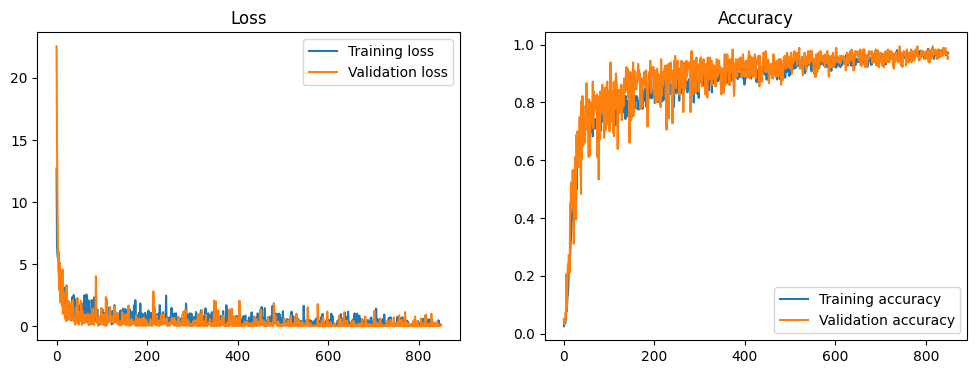

Epoch [851/1100], Loss: 0.142603799700737, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9388888888888889 Validation loss: 0.02869252860546112 Correct: 169 Total: 180
Epoch [852/1100], Loss: 0.08161110430955887, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9833333333333333 Validation loss: 0.5816043019294739 Correct: 177 Total: 180
Epoch [853/1100], Loss: 0.04134121537208557, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9944444444444445 Validation loss: 0.02489844523370266 Correct: 179 Total: 180
Epoch [854/1100], Loss: 0.15176357328891754, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9777777777777777 Validation loss: 0.03916604444384575 Correct: 176 Total: 

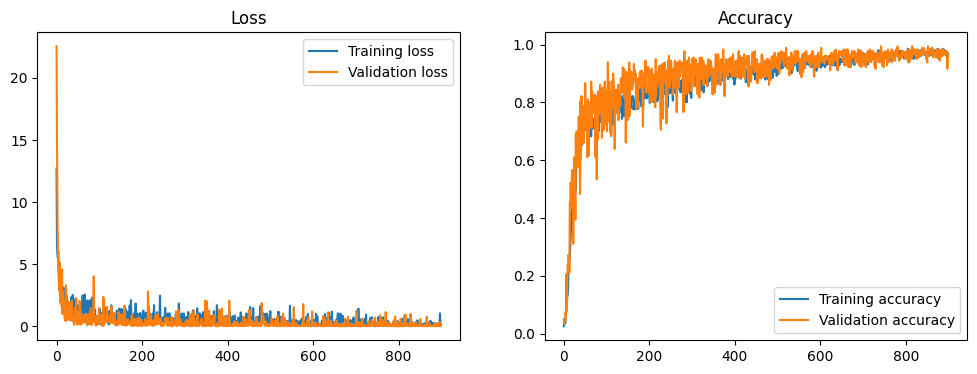

Epoch [901/1100], Loss: 0.15750469267368317, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.06629940122365952 Correct: 179 Total: 180
Epoch [902/1100], Loss: 0.5209444165229797, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.95 Validation loss: 0.02032405696809292 Correct: 171 Total: 180
Epoch [903/1100], Loss: 0.19581587612628937, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.0027164199855178595 Correct: 177 Total: 180
Epoch [904/1100], Loss: 0.403673380613327, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.020271729677915573 Correct: 172 Total: 180
Epoch [905/110

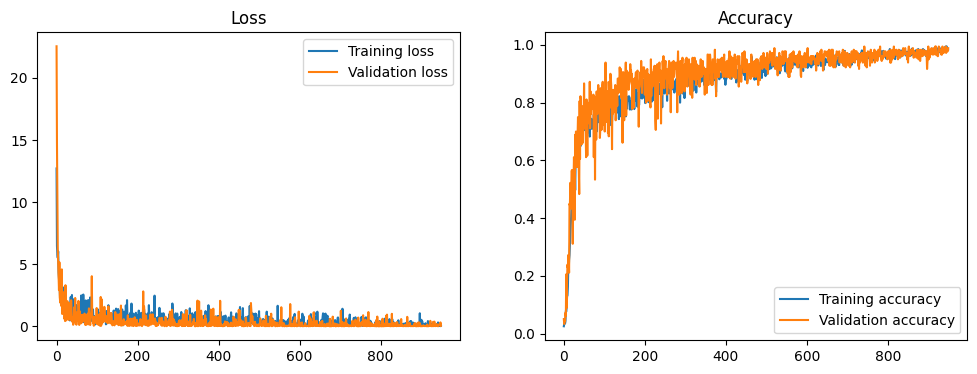

Epoch [951/1100], Loss: 0.977390468120575, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.4311142563819885 Correct: 173 Total: 180
Epoch [952/1100], Loss: 0.2587275505065918, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.006376938428729773 Correct: 175 Total: 180
Epoch [953/1100], Loss: 0.15255455672740936, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.03988828510046005 Correct: 175 Total: 180
Epoch [954/1100], Loss: 0.010783154517412186, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.05992361903190613 Correct: 179 Total: 180
Epo

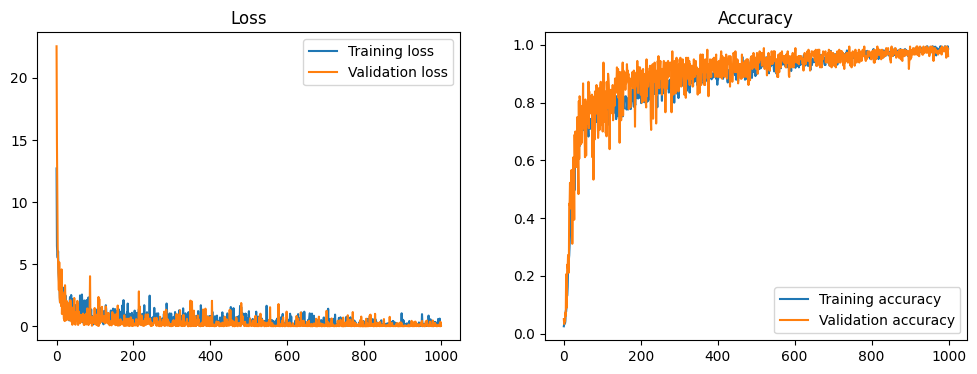

Epoch [1001/1100], Loss: 0.5478840470314026, Accuracy: 0.9873015873015873 Correct: 622 Total: 630 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 0.05632796511054039 Correct: 178 Total: 180
Epoch [1002/1100], Loss: 0.05510113760828972, Accuracy: 0.9873015873015873 Correct: 622 Total: 630 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.018684016540646553 Correct: 176 Total: 180
Epoch [1003/1100], Loss: 0.06449338048696518, Accuracy: 0.9873015873015873 Correct: 622 Total: 630 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.04987302049994469 Correct: 176 Total: 180
Epoch [1004/1100], Loss: 0.05723336338996887, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.034348517656326294 Correct: 176 Tota

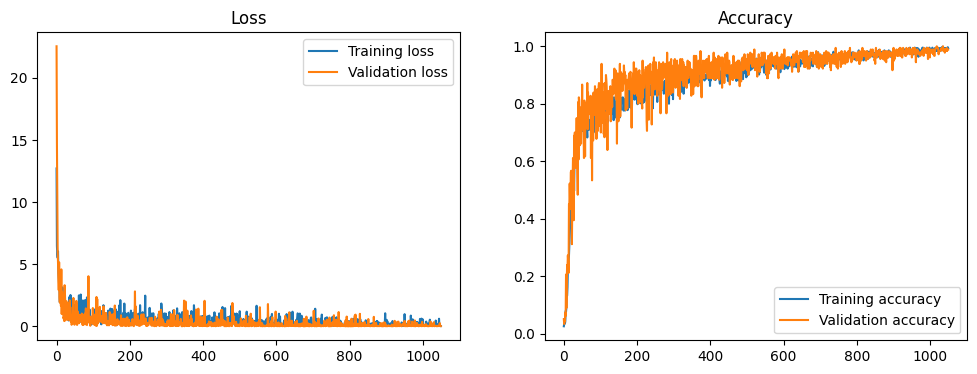

Epoch [1051/1100], Loss: 0.009733491577208042, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.01816003955900669 Correct: 179 Total: 180
Epoch [1052/1100], Loss: 0.0719716027379036, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.08593086153268814 Correct: 179 Total: 180
Epoch [1053/1100], Loss: 0.014391004107892513, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 0.05184762179851532 Correct: 178 Total: 180
Epoch [1054/1100], Loss: 0.018229274079203606, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.027344951406121254 Correct: 17

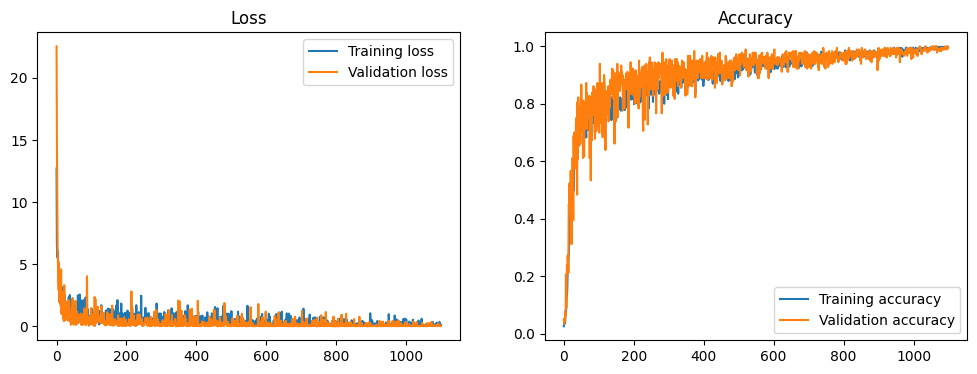

In [29]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [30]:
save_model(model, model_path)

### Results

In [31]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [32]:
print("Best validation acc: ", max(val_accuracies))
print("Last validation acc: ", val_accuracies[-1])

Best validation acc:  1.0
Last validation acc:  0.9944444444444445


In [33]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [34]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-phone.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

### Test accuracy

In [35]:
cm = predict(test_dataloader)

Test Accuracy: 1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
predicted_labels,0,A,H,O,A,S,D,1,2,2,C,2,M,3,O,B,X,X,7,4,Z,R,N,Q,W,6,9,P,C,G,9,K,N,6,V,E,R,U,F,Z,B,O,3,K,D,S,T,1,I,Y,L,I,R,P,E,V,W,7,Q,8,W,P,H,7,3,1,0,S,G,I,A,T,J,E,M,F,5,N,Y,5,J,L,X,M,6,B,4,K,8,U
true_labels,0,A,H,O,A,S,D,1,2,2,C,2,M,3,O,B,X,X,7,4,Z,R,N,Q,W,6,9,P,C,G,9,K,N,6,V,E,R,U,F,Z,B,O,3,K,D,S,T,1,I,Y,L,I,R,P,E,V,W,7,Q,8,W,P,H,7,3,1,0,S,G,I,A,T,J,E,M,F,5,N,Y,5,J,L,X,M,6,B,4,K,8,U


1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00

### Confusion matrix

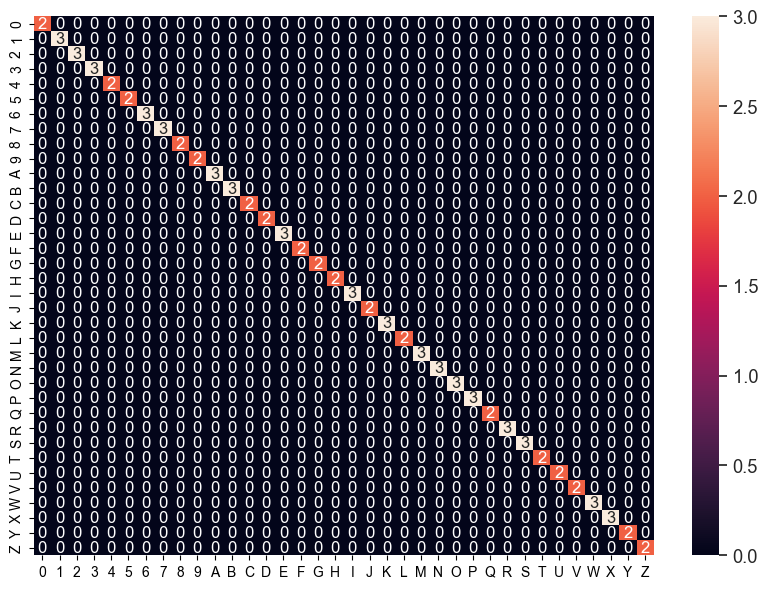

In [36]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=all_characters, 
                yticklabels=all_characters,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1-phone")